<a href="https://colab.research.google.com/github/SiracencoSerghei/DataScienceHW/blob/main/example_kaggle/les_9/improving_3_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score


In [6]:
# Налаштування параметрів
num_classes = 10
num_features = 784

learning_rate = 0.01
training_steps = 3000
batch_size = 256
display_step = 100

n_hidden_1 = 128
n_hidden_2 = 256

# Завантаження MNIST
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])
x_train, x_test = x_train / 255., x_test / 255.

In [7]:
# Оголошуємо клас повнозв'язного шару
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, activation=None):
        super().__init__()
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")
        self.activation = activation

    def __call__(self, x):
        y = tf.matmul(x, self.w) + self.b
        return self.activation(y) if self.activation else y

# Оголошуємо клас нейромережі
class NN(tf.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = DenseLayer(num_features, n_hidden_1, activation=tf.nn.sigmoid)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, activation=tf.nn.sigmoid)
        self.out_layer = DenseLayer(n_hidden_2, num_classes, activation=tf.nn.softmax)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        return self.out_layer(x)

# Функція втрат (крос-ентропія)
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))

# Функція точності
def accuracy(y_pred, y_true):
    return accuracy_score(y_true, np.argmax(y_pred, axis=1))

# Функція навчання
def train(neural_net, optimizer, x_train, y_train, method="Mini-Batch"):
    loss_history = []
    accuracy_history = []

    if method == "Batch":
        batch_x, batch_y = x_train, y_train  # Використовуємо всі дані відразу

    for step in range(1, training_steps + 1):
        if method == "Mini-Batch":
            indices = np.random.choice(x_train.shape[0], batch_size, replace=False)
            batch_x, batch_y = x_train[indices], y_train[indices]
        elif method == "SGD":
            index = np.random.randint(0, x_train.shape[0])
            batch_x, batch_y = x_train[index:index+1], y_train[index:index+1]

        with tf.GradientTape() as g:
            pred = neural_net(batch_x)
            loss = cross_entropy(pred, batch_y)

        grads = g.gradient(loss, [neural_net.layer1.w, neural_net.layer1.b,
                                  neural_net.layer2.w, neural_net.layer2.b,
                                  neural_net.out_layer.w, neural_net.out_layer.b])

        optimizer.apply_gradients(zip(grads, [neural_net.layer1.w, neural_net.layer1.b,
                                              neural_net.layer2.w, neural_net.layer2.b,
                                              neural_net.out_layer.w, neural_net.out_layer.b]))

        if step % display_step == 0:
            pred = neural_net(x_test)
            acc = accuracy(pred.numpy(), y_test)
            loss_history.append(loss.numpy())
            accuracy_history.append(acc)
            print(f"{method} | Крок {step}, Втрата: {loss.numpy():.4f}, Точність: {acc:.4f}")

    return loss_history, accuracy_history


In [8]:
# Запускаємо навчання для кожного методу
neural_net_SGD = NN()
neural_net_MiniBatch = NN()
neural_net_Batch = NN()

optimizer = tf.optimizers.SGD(learning_rate)

loss_SGD, acc_SGD = train(neural_net_SGD, optimizer, x_train, y_train, "SGD")
loss_MiniBatch, acc_MiniBatch = train(neural_net_MiniBatch, optimizer, x_train, y_train, "Mini-Batch")
loss_Batch, acc_Batch = train(neural_net_Batch, optimizer, x_train, y_train, "Batch")

SGD | Крок 100, Втрата: 14.6649, Точність: 0.1868
SGD | Крок 200, Втрата: 5.9448, Точність: 0.2016
SGD | Крок 300, Втрата: 2.1757, Точність: 0.2543
SGD | Крок 400, Втрата: 3.8456, Точність: 0.3052
SGD | Крок 500, Втрата: 15.1699, Точність: 0.3669
SGD | Крок 600, Втрата: 2.6379, Точність: 0.3874
SGD | Крок 700, Втрата: 5.9660, Точність: 0.4042
SGD | Крок 800, Втрата: 5.3377, Точність: 0.4475
SGD | Крок 900, Втрата: 8.5064, Точність: 0.4699
SGD | Крок 1000, Втрата: 5.5309, Точність: 0.4986
SGD | Крок 1100, Втрата: 1.8887, Точність: 0.4923
SGD | Крок 1200, Втрата: 0.0183, Точність: 0.4618
SGD | Крок 1300, Втрата: 0.1496, Точність: 0.5293
SGD | Крок 1400, Втрата: 5.8503, Точність: 0.5553
SGD | Крок 1500, Втрата: 0.0017, Точність: 0.5422
SGD | Крок 1600, Втрата: 6.3329, Точність: 0.5397
SGD | Крок 1700, Втрата: 6.8057, Точність: 0.5743
SGD | Крок 1800, Втрата: 0.0105, Точність: 0.5971
SGD | Крок 1900, Втрата: 0.0874, Точність: 0.5996
SGD | Крок 2000, Втрата: 0.7205, Точність: 0.5675
SGD | К

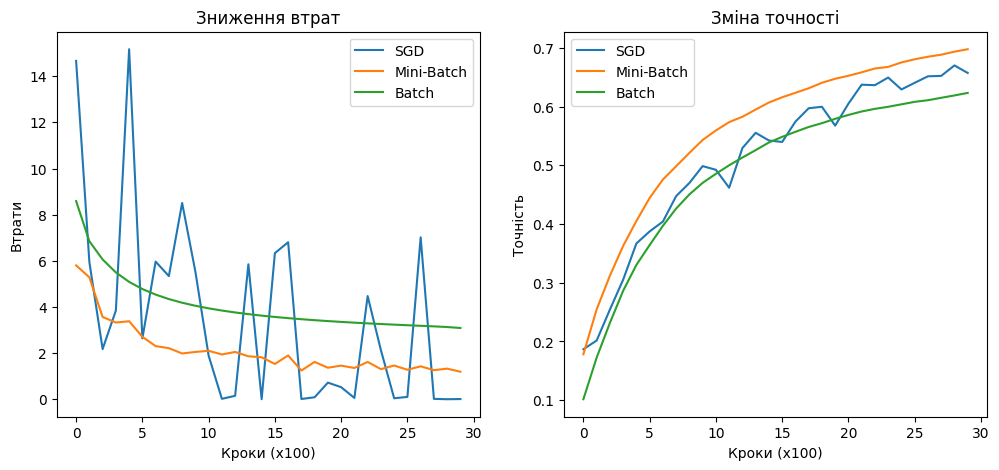

In [9]:
# Візуалізація результатів
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_SGD, label='SGD')
plt.plot(loss_MiniBatch, label='Mini-Batch')
plt.plot(loss_Batch, label='Batch')
plt.xlabel("Кроки (x100)")
plt.ylabel("Втрати")
plt.legend()
plt.title("Зниження втрат")

plt.subplot(1, 2, 2)
plt.plot(acc_SGD, label='SGD')
plt.plot(acc_MiniBatch, label='Mini-Batch')
plt.plot(acc_Batch, label='Batch')
plt.xlabel("Кроки (x100)")
plt.ylabel("Точність")
plt.legend()
plt.title("Зміна точності")

plt.show()

## Цей проєкт порівнює різні методи оптимізації градієнтного спуску:

- **SGD** (Стохастичний ГС) → оновлює ваги після кожного зразка.
- **Mini-Batch** (Міні-пакетний ГС) → оновлює ваги після кожного пакету.
- **Batch** (Пакетний ГС) → оновлює ваги після обробки всього датасету.

Оптимізація та оновлення ваг відбувається по-різному для кожного методу.

### Графічний аналіз
Додається графічний аналіз, щоб порівняти втрати та точність.

### 📊 Очікувані результати:
- **SGD** зазвичай коливається, бо оновлює ваги після кожного зразка.
- **Batch GD** конвергує плавно, але повільніше.
- **Mini-Batch GD** є компромісом між швидкістю та стабільністю.
